# Experiments

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import time
import seaborn as sns

from models import *
from utils import *

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Approximate BNNs
### Feedforward BNN

In [2]:
X_train, Y_train = load_data('./data/', 'abnn_ff_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_ff_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_ff_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=50,
    **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.255809247493744, time elapsed: 3 m 38 s


KeyboardInterrupt: 

Best hidden unit: 256, best layers: 3


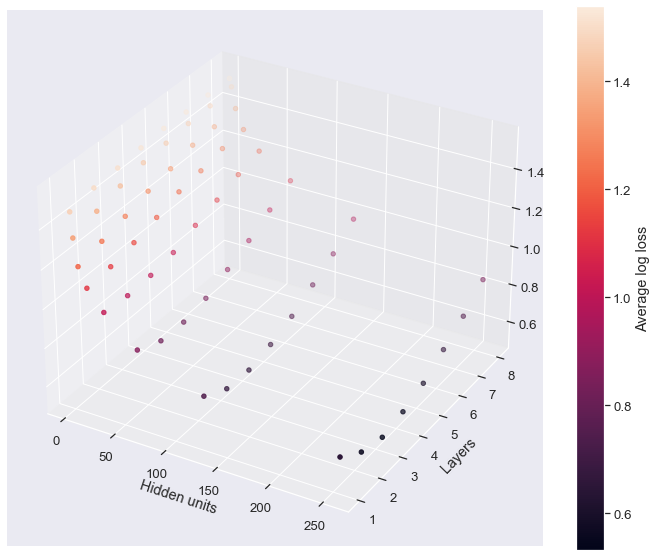

In [8]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_log_ff')

####  2. Learning with best parameter

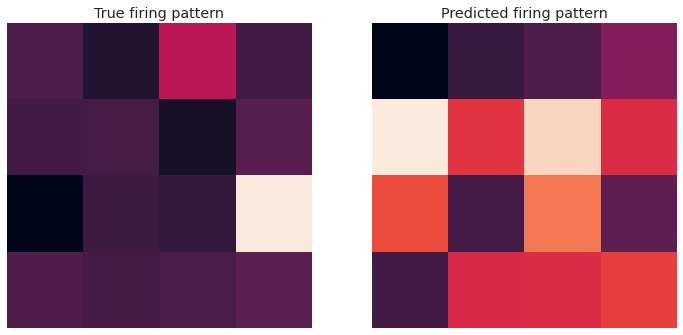

Initial eval loss: 4.69523298740387
Epoch 1: training loss 36.68087023496628, eval loss 3.0915587544441223. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 28.851396083831787, eval loss 2.6946181058883667. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 25.6065870821476, eval loss 2.4122732281684875. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 23.367661982774734, eval loss 2.208168715238571. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 21.711021974682808, eval loss 2.0505310893058777. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 20.27371659874916, eval loss 1.9597993195056915. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 19.088912293314934, eval loss 1.8796273469924927. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 18.17594785988331, eval loss 1.7910193800926208. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 17.089602395892143, eval loss 1.7434249818325043. Time elapsed: 0 h 0 m 0 s.
Epoch 10: training loss 16.06836622953415, eval loss 1.713167101144790

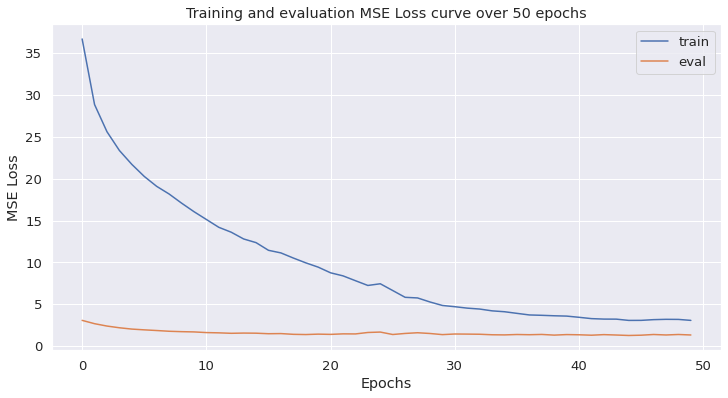

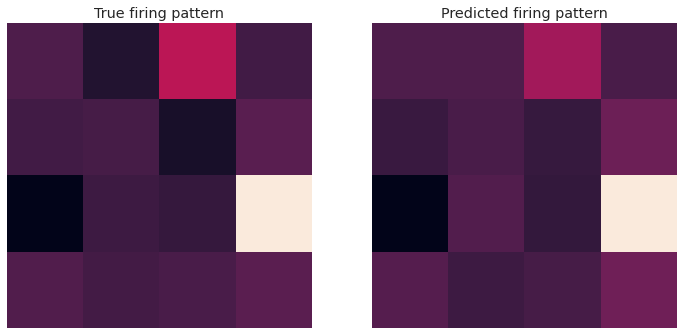

In [7]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_train[13,:], DNN(X_train[13,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_train[13,:], DNN(X_train[13,:])) # visualise after training

#### 3. Testing against predicting the mean

In [13]:
with torch.no_grad():
    pred_mean = DNN(X_train)
    
print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))

DNN prediction MSE error on test set:  tensor(0.2694, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.9366, device='cuda:0')


/tmp/ipykernel_68121/4047130697.py:5: UserWarning: Using a target size (torch.Size([1000, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))


### Residual BNN

In [5]:
X_train, Y_train = load_data('./data/', 'abnn_resid_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_resid_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_resid_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [ ]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=50, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.4395582675933838, time elapsed: 3 m 31 s


In [6]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_resid')

NameError: name 'avg_final_eval_loss' is not defined

#### 2. Learning with best parameter

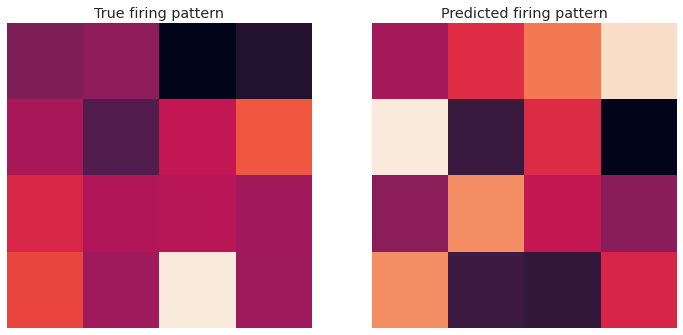

Initial eval loss: 0.9296042323112488
Epoch 1: training loss 35.41237357258797, eval loss 0.5835528373718262. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 26.845576971769333, eval loss 0.5044731497764587. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 23.38831102848053, eval loss 0.4581342935562134. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 20.752306580543518, eval loss 0.41492751240730286. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 18.659853249788284, eval loss 0.3922276496887207. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 17.32726077735424, eval loss 0.3703906238079071. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 16.172224014997482, eval loss 0.369241327047348. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 15.384531408548355, eval loss 0.35196515917778015. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 14.655884206295013, eval loss 0.364605575799942. Time elapsed: 0 h 0 m 0 s.
Epoch 10: training loss 14.056853130459785, eval loss 0.336463004

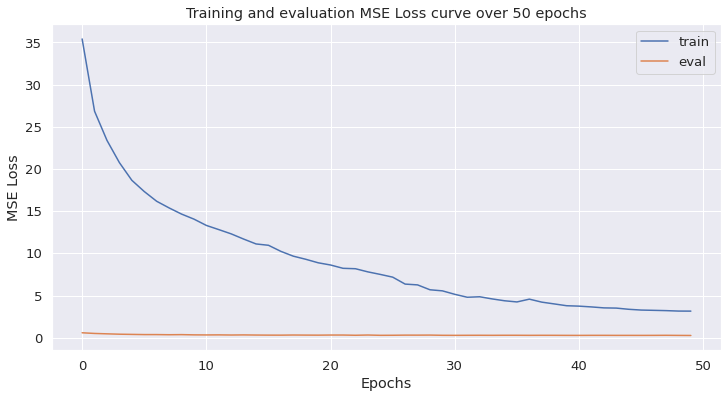

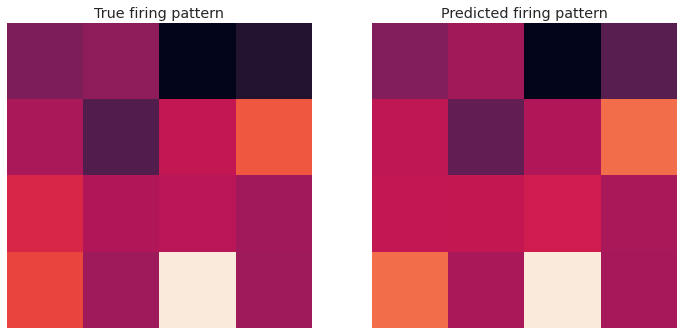

In [7]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_train[v_idx,:], DNN(X_train[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_train[v_idx,:], DNN(X_train[v_idx,:])) # visualise after training

#### 3. Testing against predicting the mean

In [8]:
with torch.no_grad():
    pred_mean = DNN(X_train)
    
print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))

DNN prediction MSE error on test set:  tensor(0.2636, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.9281, device='cuda:0')


/tmp/ipykernel_79743/4047130697.py:5: UserWarning: Using a target size (torch.Size([100, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))


### Recurrent RNN

In [3]:
X_train, Y_train = load_data('./data/', 'abnn_recur_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_recur_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_recur_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

200

#### 2. Learning with best parameter

In [4]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_layers=1, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')


RuntimeError: For batched 3-D input, hx and cx should also be 3-D but got (1-D, 1-D) tensors

In [ ]:
%debug

> /home/daniel/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py(747)forward()
    745                         msg = ("For batched 3-D input, hx and cx should "
    746                                f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors")
--> 747                         raise RuntimeError(msg)
    748                 else:
    749                     if hx[0].dim() != 2 or hx[1].dim() != 2:



ipdb>  c_prev


*** NameError: name 'c_prev' is not defined
